# WallStreetBets Tracker with PostgreSQL
#### Alvee Hoque 06/08/21

Tasks:
- Create SQL tables
- Populate stocks/etfs
- Get tickers from WallStreetBets subreddit 
- Get price data from yfinance



## Imports

In [1]:
# import config file
import config

# import postgresql packages
import psycopg2
import psycopg2.extras

# imports
import pandas as pd 
import numpy as np
import seaborn as sns

# price collection 
import yfinance as yf

# imports for reddit and datetime/text manipulation
import praw
import datetime
import re

In [2]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style('darkgrid')

## Create Tables

In [3]:
# Establish connection and cursor
con = psycopg2.connect(database=config.db,user=config.db_user,password=config.db_password)
con.autocommit = True
# dictionary cursor easier to work with 
cursor = con.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [4]:
# create tables: 

create_stocks = '''
CREATE TABLE IF NOT EXISTS stocks 
(id SERIAL,
symbol TEXT NOT NULL PRIMARY KEY,
name TEXT NOT NULL,
sector TEXT NOT NULL,
industry TEXT NOT NULL);
'''

create_price ='''
CREATE TABLE IF NOT EXISTS price 
(symbol TEXT NOT NULL, 
datetime TIMESTAMP WITHOUT TIME ZONE NOT NULL,
open NUMERIC NOT NULL,
high NUMERIC NOT NULL,
low NUMERIC NOT NULL,
close NUMERIC NOT NULL,
constraint fk_stock foreign key(symbol) references stocks(symbol)); 
'''

create_hot = '''
CREATE TABLE IF NOT EXISTS hot 
(symbol TEXT NOT NULL,
datetime TIMESTAMP WITHOUT TIME ZONE NOT NULL,
post TEXT NOT NULL, 
source TEXT NOT NULL,
url TEXT NOT NULL,
constraint fk_stock foreign key(symbol) references stocks(symbol)); '''


cursor.execute(create_stocks)
print('Stock table created')

cursor.execute(create_price)
print('Price table created')

cursor.execute(create_hot)
print('Hot table created')


Stock table created
Price table created
Hot table created


## Populate Stocks

In [5]:
# read csv file all_tickers
all_tickers = pd.read_csv('all_tickers.csv')
all_tickers.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACG,ATA Creativity Global American Depositary Shares,$2.81,-0.28,-9.061%,8.908034e+07,China,NaN,228677,Consumer Services,Other Consumer Services
1,AACQ,Artius Acquisition Inc. Class A Common Stock,$10.01,-0.03,-0.299%,9.065306e+08,United States,2020.0,1147413,Basic Industries,Major Chemicals
2,AACQU,Artius Acquisition Inc. Unit,$10.50,-0.05,-0.474%,0.000000e+00,United States,2020.0,29390,Basic Industries,Major Chemicals
3,AACQW,Artius Acquisition Inc Warrant,$1.63,-0.02,-1.212%,0.000000e+00,United States,2020.0,285263,Basic Industries,Major Chemicals
4,AAL,American Airlines Group Inc. Common Stock,$22.03,-0.10,-0.452%,1.412948e+10,United States,NaN,25908689,Transportation,Air Freight/Delivery Services


In [6]:
# all_tickers[['Symbol','Name']]

In [7]:
# Populate Stocks Table with symbol,name,sector,industry 
for i in range(len(all_tickers)):
    cursor.execute('''INSERT INTO stocks (symbol, name, sector, industry)
    VALUES (%s, %s, %s, %s)''', (all_tickers.Symbol[i], all_tickers.Name[i], all_tickers.Sector[i], all_tickers.Industry[i]))

## Populate ETF


In [8]:
# read etf list 
etf = pd.read_csv('top_100_etf.csv')
etf.head()

,Symbol,Name,Index,Market cap,Current yield,Avg Volume,Action
0,SPY,SPDR S&P 500 ETF,S&P 500 Index,"$366,017,985,000",1.33%,"68,176,867",Analyze
1,IVV,iShares Core S&P 500 Index Fund ETF,S&P 500 Index,"$277,915,140,000",1.35%,"4,643,738",Analyze
2,VTI,Vanguard Total Stock Market ETF,CRSP US Total Market Index,"$234,253,476,097",1.30%,"3,839,977",Analyze
3,VOO,Vanguard S&P 500 ETF,S&P 500 Index,"$216,368,492,031",1.40%,"3,836,766",Analyze
4,QQQ,Invesco QQQ ETF,NASDAQ-100 Index,"$158,312,784,500",0.53%,"33,846,971",Analyze


In [9]:
# Make sector/industry into etf so it is compatible with stock table
etf = etf[['Symbol','Name','Index']]
etf['Industry'] = 'ETF'
etf.rename(columns={'Index':'Sector'},inplace=True)
etf.head()

,Symbol,Name,Sector,Industry
0,SPY,SPDR S&P 500 ETF,S&P 500 Index,ETF
1,IVV,iShares Core S&P 500 Index Fund ETF,S&P 500 Index,ETF
2,VTI,Vanguard Total Stock Market ETF,CRSP US Total Market Index,ETF
3,VOO,Vanguard S&P 500 ETF,S&P 500 Index,ETF
4,QQQ,Invesco QQQ ETF,NASDAQ-100 Index,ETF


In [10]:
# Put into SQL Table
for i in range(len(etf)):
    cursor.execute('''INSERT INTO stocks (symbol, name, sector, industry)
    VALUES (%s, %s, %s, %s)''', (etf.Symbol[i], etf.Name[i], etf.Sector[i], etf.Industry[i]))

In [11]:
# Combine Symbols for Stocks and ETFs 
symbols = pd.concat((all_tickers,etf))
symbols = symbols['Symbol'].tolist()

## WallStreetBets Trending Tickers 

In [12]:
# Reddit Keys
client_id = config.client_id  
client_secret = config.client_secret 
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.72 Safari/537.36')

In [13]:
subreddit = reddit.subreddit('wallstreetbets')

# list of non tickers
not_tickers = ['A','B','GO','ARE','ON','YOU','DD','YOLO','OK','TD']

In [14]:
for post in subreddit.top('week',limit=2500):
    ticker = []
    
    # post title
    title = post.title
    
    # split into words, search for first ticker mentioned
    words = re.sub(r'[^\w\s]', '', title)
    words = words.split(' ')
    
    for word in words: 
        if word in symbols and word not in not_tickers:
            ticker = word
            break
        else: 
            ticker = None 
    

    # change datetime:
    post_time = datetime.datetime.fromtimestamp(post.created_utc).isoformat()
    
    if ticker != None:
    
         cursor.execute("""INSERT INTO hot (symbol, datetime, post, source, url)
                    VALUES (%s, %s, %s, 'wsb', %s )
                    """, (ticker, post_time, post.title,post.url))
    

## Top 10 Trending Tickers 

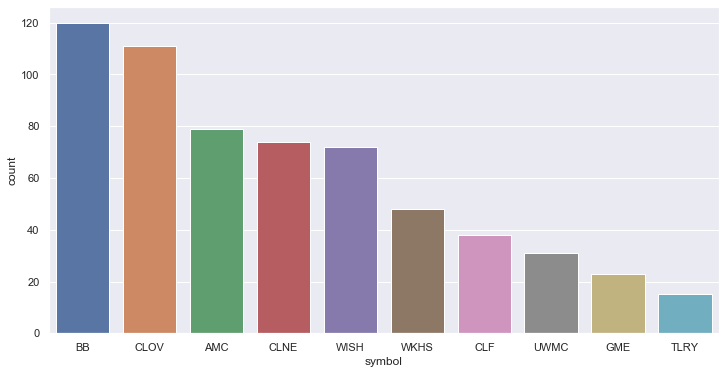

In [15]:
# Collect Data
cursor.execute("""SELECT * FROM hot""")
data = cursor.fetchall()

# Put in Dataframe 
wsb_df = pd.DataFrame(data,columns=['symbol','datetime','post','source','url'])

# Countplot of Top 10 Trending 
sns.countplot(x=wsb_df['symbol'], order=wsb_df.symbol.value_counts().index[:10])

In [16]:
# GET TOP 10 DAILY PRICE AND INSERT INTO SQL DATABASE

In [17]:
# Inserting Price Into SQL for Future Analysis 
top_10 = wsb_df['symbol'].value_counts()[:10].index.tolist()
tickers = yf.Tickers(top_10)
df = tickers.history(period='1y',auto_adjust=True,actions=False,group_by='Ticker')
df = df.round(2)

for i in range(len(top_10)):
    ticker = df.columns.levels[0][i]
    
    
    for j in range(len(df)):
        cursor.execute('''INSERT INTO price (symbol, datetime, open, high, low, close)
        VALUES (%s, %s, %s, %s, %s, %s)''', (ticker, df.index[j], 
                                             df[ticker].Open[j], df[ticker].High[j], 
                                             df[ticker].Low[j], df[ticker].Close[j]))


[*********************100%***********************]  10 of 10 completed
